In [1]:
from itertools import product

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from download_data import get_price, get_mpd, get_fx
from data_analysis.explore_data import (
    calc_rolling_stat,
    merge_prob_stat,
    rename_stat_df,
    eval_large_change_prob,
    plot_change_scatter,
    prep_regression_stat,
    compare_regressions,
    compare_regression_eval
)

In [2]:
data = get_mpd()
start_date, end_date = data["idt"].min(), data["idt"].max()
print(start_date, end_date)

2006-01-12 00:00:00 2024-01-10 00:00:00


In [3]:
fx = data.loc[data["type"].isin(["fx"])]
fx.groupby("market").first()

,idt,maturity_target,mu,sd,skew,kurt,p10,p50,p90,lg_change_decr,prDec,lg_change_incr,prInc,name,type
market,,,,,,,,,,,,,,,
euro,2011-04-29 00:00:00,3.0,-0.003680,0.062659,-0.322283,0.407039,-0.084137,-0.001107,0.073021,-10.0,0.069296,10.0,0.039502,Euro-USD exchange rate (CME),fx
pound,2011-04-29 00:00:00,3.0,-0.002033,0.048537,-0.326350,0.713841,-0.062991,-0.000362,0.056491,-10.0,0.033302,10.0,0.014766,Pound-USD exchange rate (CME),fx
yen,2011-04-29 00:00:00,3.0,-0.003274,0.059893,0.213295,0.747921,-0.075532,-0.005217,0.071314,-10.0,0.049025,10.0,0.049149,Yen-USD exchange rate (CME),fx


In [4]:
equity = data.loc[data["type"].isin(["equity", "equity_idx"])]
equity.groupby("market").first()

,idt,maturity_target,mu,sd,skew,kurt,p10,p50,p90,lg_change_decr,prDec,lg_change_incr,prInc,name,type
market,,,,,,,,,,,,,,,
bac,2010-01-15 00:00:00,3.0,-0.025140,0.182100,-0.381730,0.851920,-0.253890,-0.016340,0.192720,-20.0,0.148980,20.0,0.093070,Bank of America Corporation,equity
citi,2010-01-15 00:00:00,3.0,-0.027030,0.216670,-0.126270,1.298230,-0.289140,-0.022310,0.226320,-20.0,0.182470,20.0,0.123160,"Citigroup, Inc.",equity
iyr,2010-10-29 00:00:00,3.0,-0.015380,0.136965,-0.948440,1.454774,-0.196561,0.005729,0.135344,-20.0,0.097426,20.0,0.022713,iShares real estate index,equity_idx
sp12m,2007-01-12 00:00:00,12.0,0.034318,0.132616,-1.055814,1.657518,-0.142450,0.057748,0.176416,-20.0,0.061515,20.0,0.056906,"S&P 500, 12-months-out",equity_idx
sp6m,2007-01-12 00:00:00,6.0,0.018803,0.086435,-1.079705,1.837194,-0.095498,0.033820,0.111149,-20.0,0.024242,20.0,0.001915,"S&P 500, 6-months-out",equity_idx


Manually translate name -> stock ticker. SPX is not a tradeable asset, therefore using SPY ETF as approximation.

Also, we can't fetch BAC data with others, hence do it separately.

In [5]:
fx = get_fx(tickers=["GBP", "EUR", "JPY"],
            start_date=start_date,
            end_date=end_date,
            use_cache=False)

In [6]:
close = get_price(tickers=["BAC", "C", "IYR", "SPY"], 
                  start_date=start_date, 
                  end_date=end_date, 
                  use_cache=False)
close = pd.concat([fx, close], axis=1)
close.head()

,EUR,GBP,JPY,BAC,C,IYR,SPY
date,,,,,,,
2006-01-12,0.829958,0.567039,113.974697,31.370887,335.512052,35.586933,91.051694
2006-01-13,0.825866,0.564469,114.457586,31.370887,334.759323,35.013371,90.966856
2006-01-14,0.827567,0.564547,114.464902,NaN,NaN,NaN,NaN
2006-01-15,0.827567,0.564547,114.464902,NaN,NaN,NaN,NaN
2006-01-16,0.825142,0.565478,114.801784,NaN,NaN,NaN,NaN


As mentioned in the methodology paper, all probability are 6-month probability.

In [19]:
stat = calc_rolling_stat(close, month=6)
market_list = ["bac", "citi", "iyr", "sp6m", "sp12m", "euro", "pound", "yen"]
ticker_list = ["BAC", "C", "IYR", "SPY", "SPY", "GBP", "EUR", "JPY"]
stat_rename = rename_stat_df(stat, dict(zip(market_list, ticker_list)))
df = merge_prob_stat(stat_rename, data)
df.head()

prDec    prInc       ret       vol   ret_max   ret_min
market idt                                                                 
bac    2010-01-15  0.14898  0.09307 -0.028342  1.059294  0.181291 -0.118014
       2010-01-29  0.16750  0.12009  0.024398  1.013638  0.250020 -0.049284
       2010-02-12  0.16404  0.12713  0.065437  0.927135  0.299305  0.000000
       2010-02-26  0.12882  0.09233 -0.069481  0.960727  0.156988 -0.115119
       2010-03-15  0.11325  0.09545 -0.082599  1.151690  0.134412 -0.206784

## 1. Evaluate Large Change
We compare average probability of group with large / negative positive change.

For equity, a higher PrInc / PrDec probability seems to indicate large positive change, despite the definition of PrDec.
For FX, a higher PrInc / PrDec probability seems to indicate large negative change, despite the definition of PrInc.

In [8]:
eval_large_change_prob(df.loc[["bac", "citi", "iyr", "sp6m", "sp12m"]], ub=0.2, lb=-0.2)

prDec                         prInc                    
             -1         0         1        -1         0         1
bac    0.094804  0.088012  0.119256  0.064787  0.061205  0.089620
citi   0.086529  0.088456  0.129593  0.044019  0.055901  0.098369
iyr    0.072796  0.121097  0.247461  0.028266  0.089703  0.314639
sp6m   0.128613  0.079427  0.222377  0.086830  0.031109  0.219041
sp12m  0.185345  0.136212  0.256893  0.183320  0.100511  0.256174

In [9]:
eval_large_change_prob(df.loc[["euro", "pound", "yen"]], ub=0.1, lb=-0.1)

prDec                         prInc                    
             -1         0         1        -1         0         1
euro   0.033515  0.018440  0.019341  0.026565  0.013682  0.011082
pound  0.073438  0.023745  0.010062  0.072008  0.014827  0.002797
yen    0.039173  0.019352  0.017950  0.050777  0.026296  0.020279

## 2. Scatter Plot

We plot the scatter plot of ret / vol / ret_min / ret_vol -> prInc / prDec.

Both plot and average probability in different actual log return scenario shows:
- prDec / prInc are only positively correlated with log return (correct only in case of prInc)
- SPY has a skewed convex shape, i.e. when no large change log_return, both prDec / prInc are low (this is correct). However, when there is a large change both prInc / prDec has large value. 

Our strategy maybe more related to volatility? i.e. large change or no change
e.g. spread trading but adjusting price band size regularly based on probability estimation

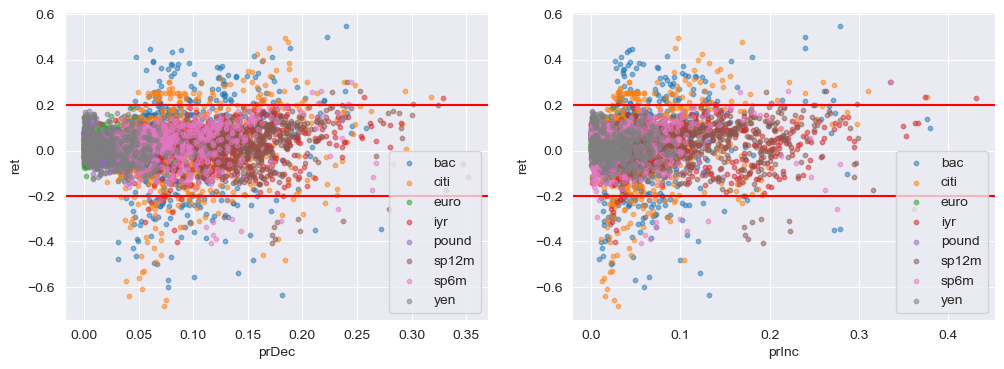

In [10]:
plot_change_scatter(df=df, col="ret", hline_levels=[-0.2, 0.2])

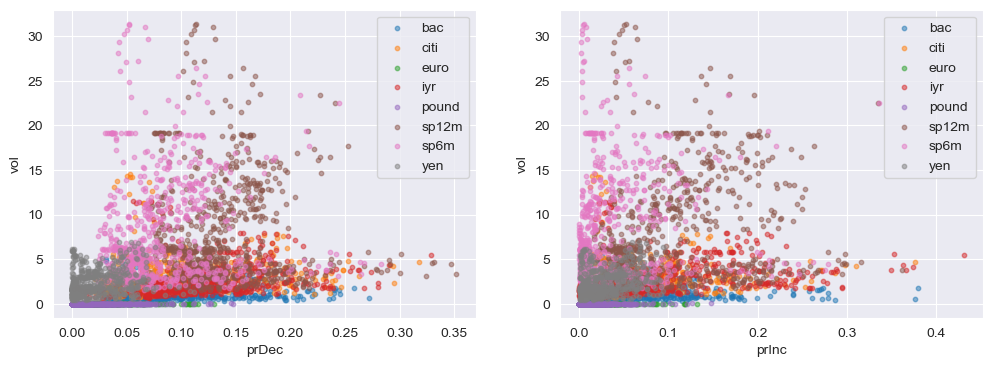

In [11]:
plot_change_scatter(df=df, col="vol")

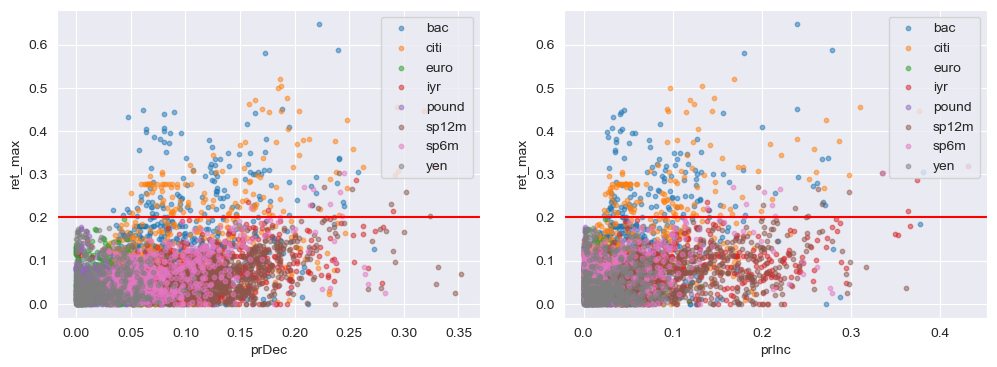

In [14]:
plot_change_scatter(df=df, col="ret_max", hline_levels=[0.2])

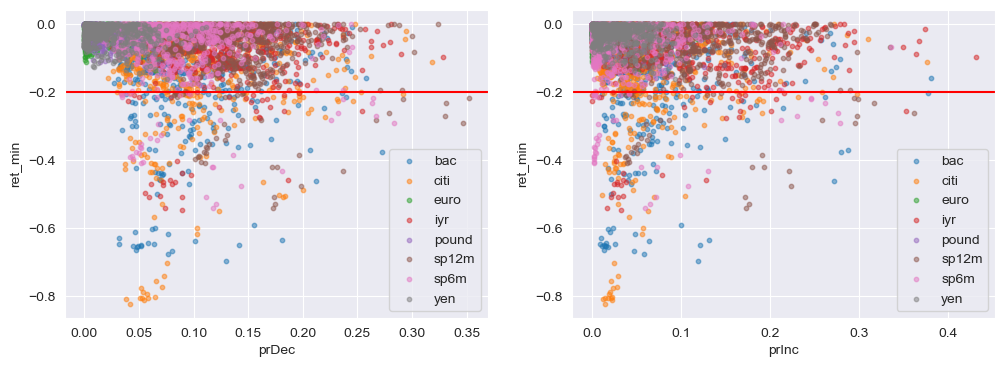

In [15]:
plot_change_scatter(df=df, col="ret_min", hline_levels=[-0.2])

## 3. Time-Series Regression

We ran time-series regression, i.e. SARIMA, GARCH, MarkovRegression with and without probability data and compare the model accuracy.


#### 3.1. Preparation
This part, we made 3 plots:
- ACF / PACF: to evaluate p, q for ARIMA / GARCH model. 
- Seasonal Decompose: to evaluate seasonal trend in a model.
- FFT Power Spectrum: to find most seasonal period.

Findings:
1. ACF shows significance for period <= 6 * 2W (p=6) and PACF shows significant <= 2 * 2W (q=2). However, one problem here is we are using bi-weekly interval data of 6 month returns. Therefore, time-series modeling would constantly peeking into future data.
2.  FFT shows different seasonality for all different series.

/Users/claircui/PycharmProjects/iaqf-default/data_analysis/explore_data.py:246: RuntimeWarning: divide by zero encountered in divide
  ax_f[n].stem(1 / freq, power_spectrum)
/Users/claircui/PycharmProjects/iaqf-default/data_analysis/explore_data.py:246: RuntimeWarning: divide by zero encountered in divide
  ax_f[n].stem(1 / freq, power_spectrum)
/Users/claircui/PycharmProjects/iaqf-default/data_analysis/explore_data.py:246: RuntimeWarning: divide by zero encountered in divide
  ax_f[n].stem(1 / freq, power_spectrum)
/Users/claircui/PycharmProjects/iaqf-default/data_analysis/explore_data.py:246: RuntimeWarning: divide by zero encountered in divide
  ax_f[n].stem(1 / freq, power_spectrum)
/Users/claircui/PycharmProjects/iaqf-default/data_analysis/explore_data.py:246: RuntimeWarning: divide by zero encountered in divide
  ax_f[n].stem(1 / freq, power_spectrum)
/Users/claircui/PycharmProjects/iaqf-default/data_analysis/explore_data.py:246: RuntimeWarning: divide by zero encountered in divi

{'bac': 183.0,
 'citi': 104.57142857142857,
 'euro': 166.5,
 'iyr': 115.33333333333334,
 'pound': 133.2,
 'sp12m': 177.99999999999997,
 'sp6m': 177.99999999999997,
 'yen': 66.6}

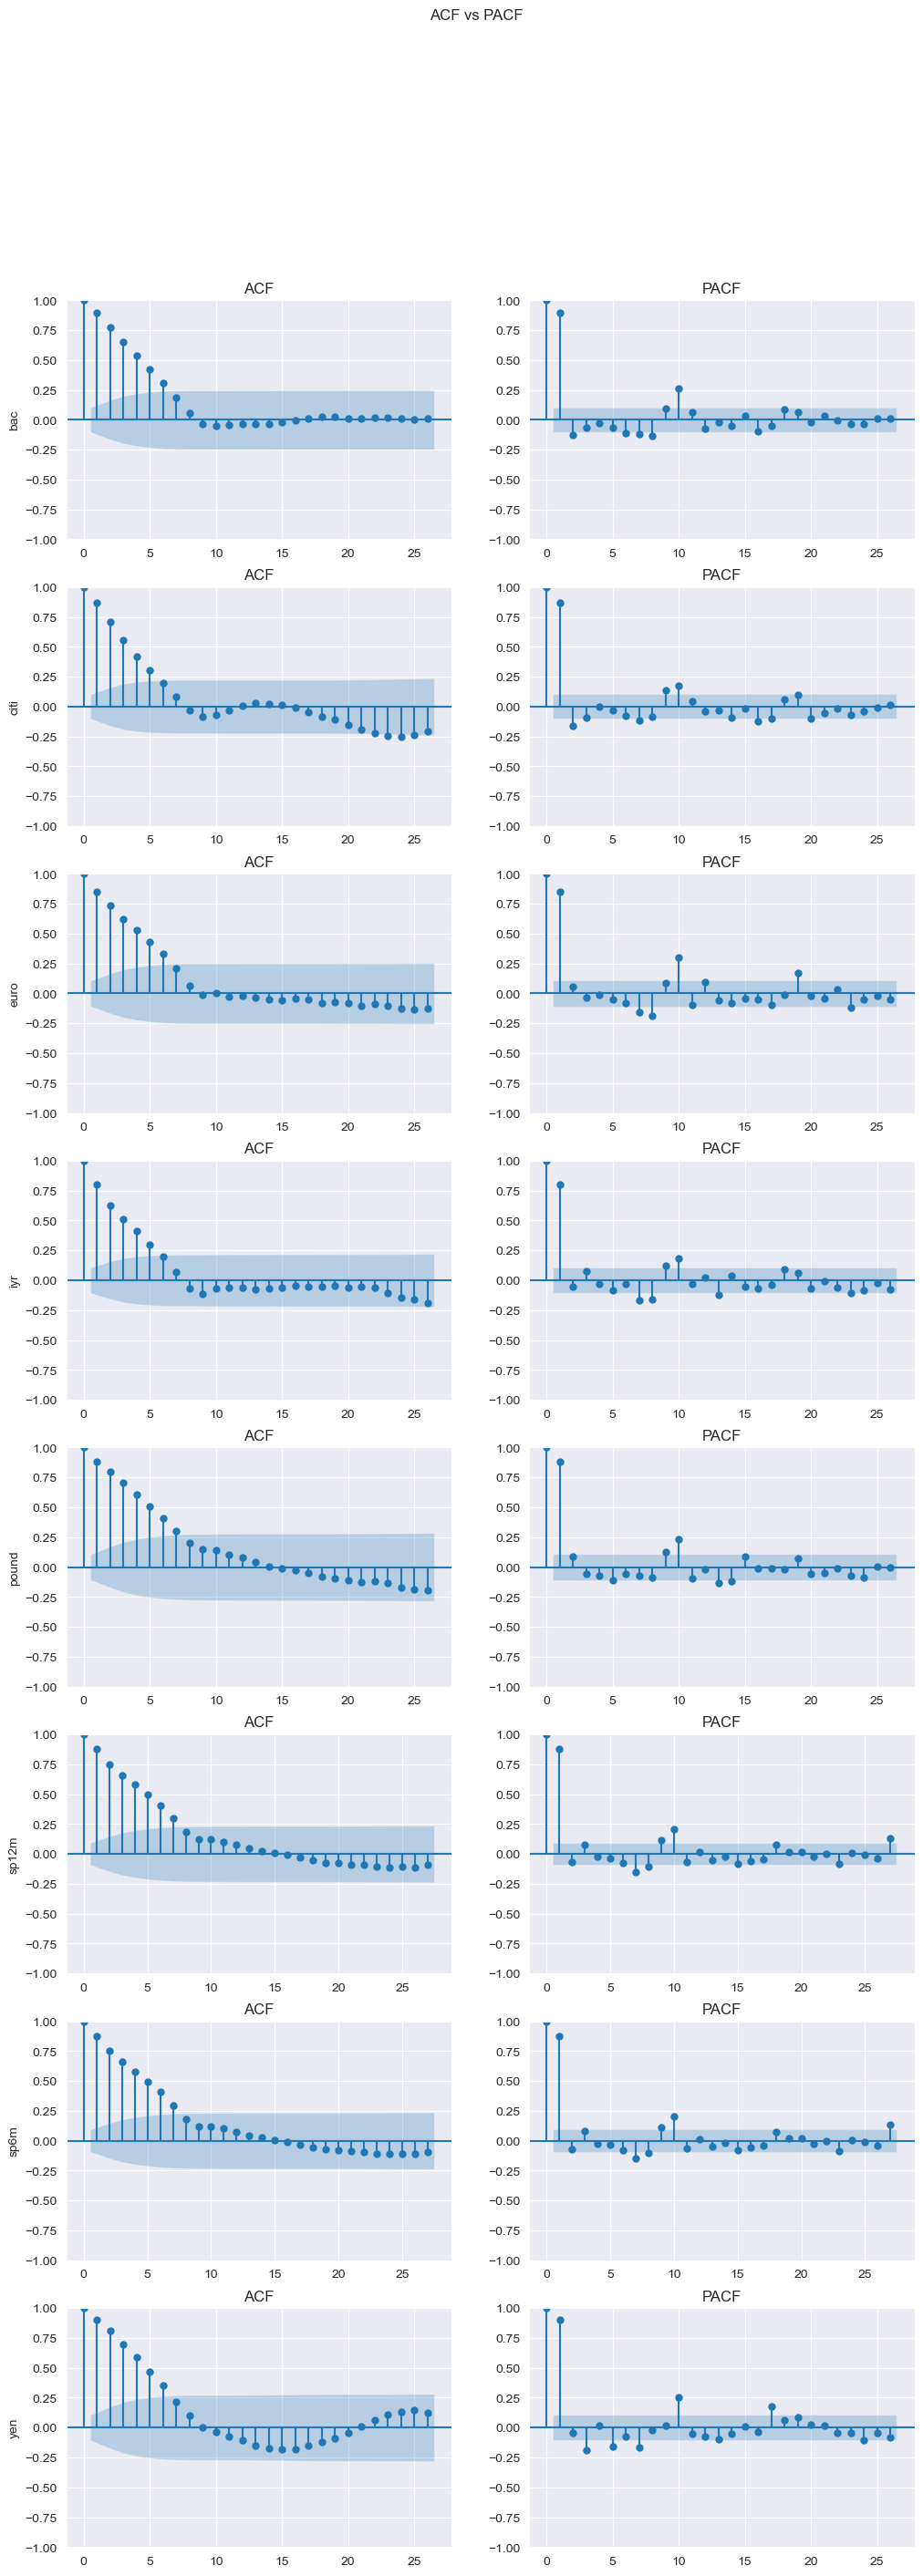

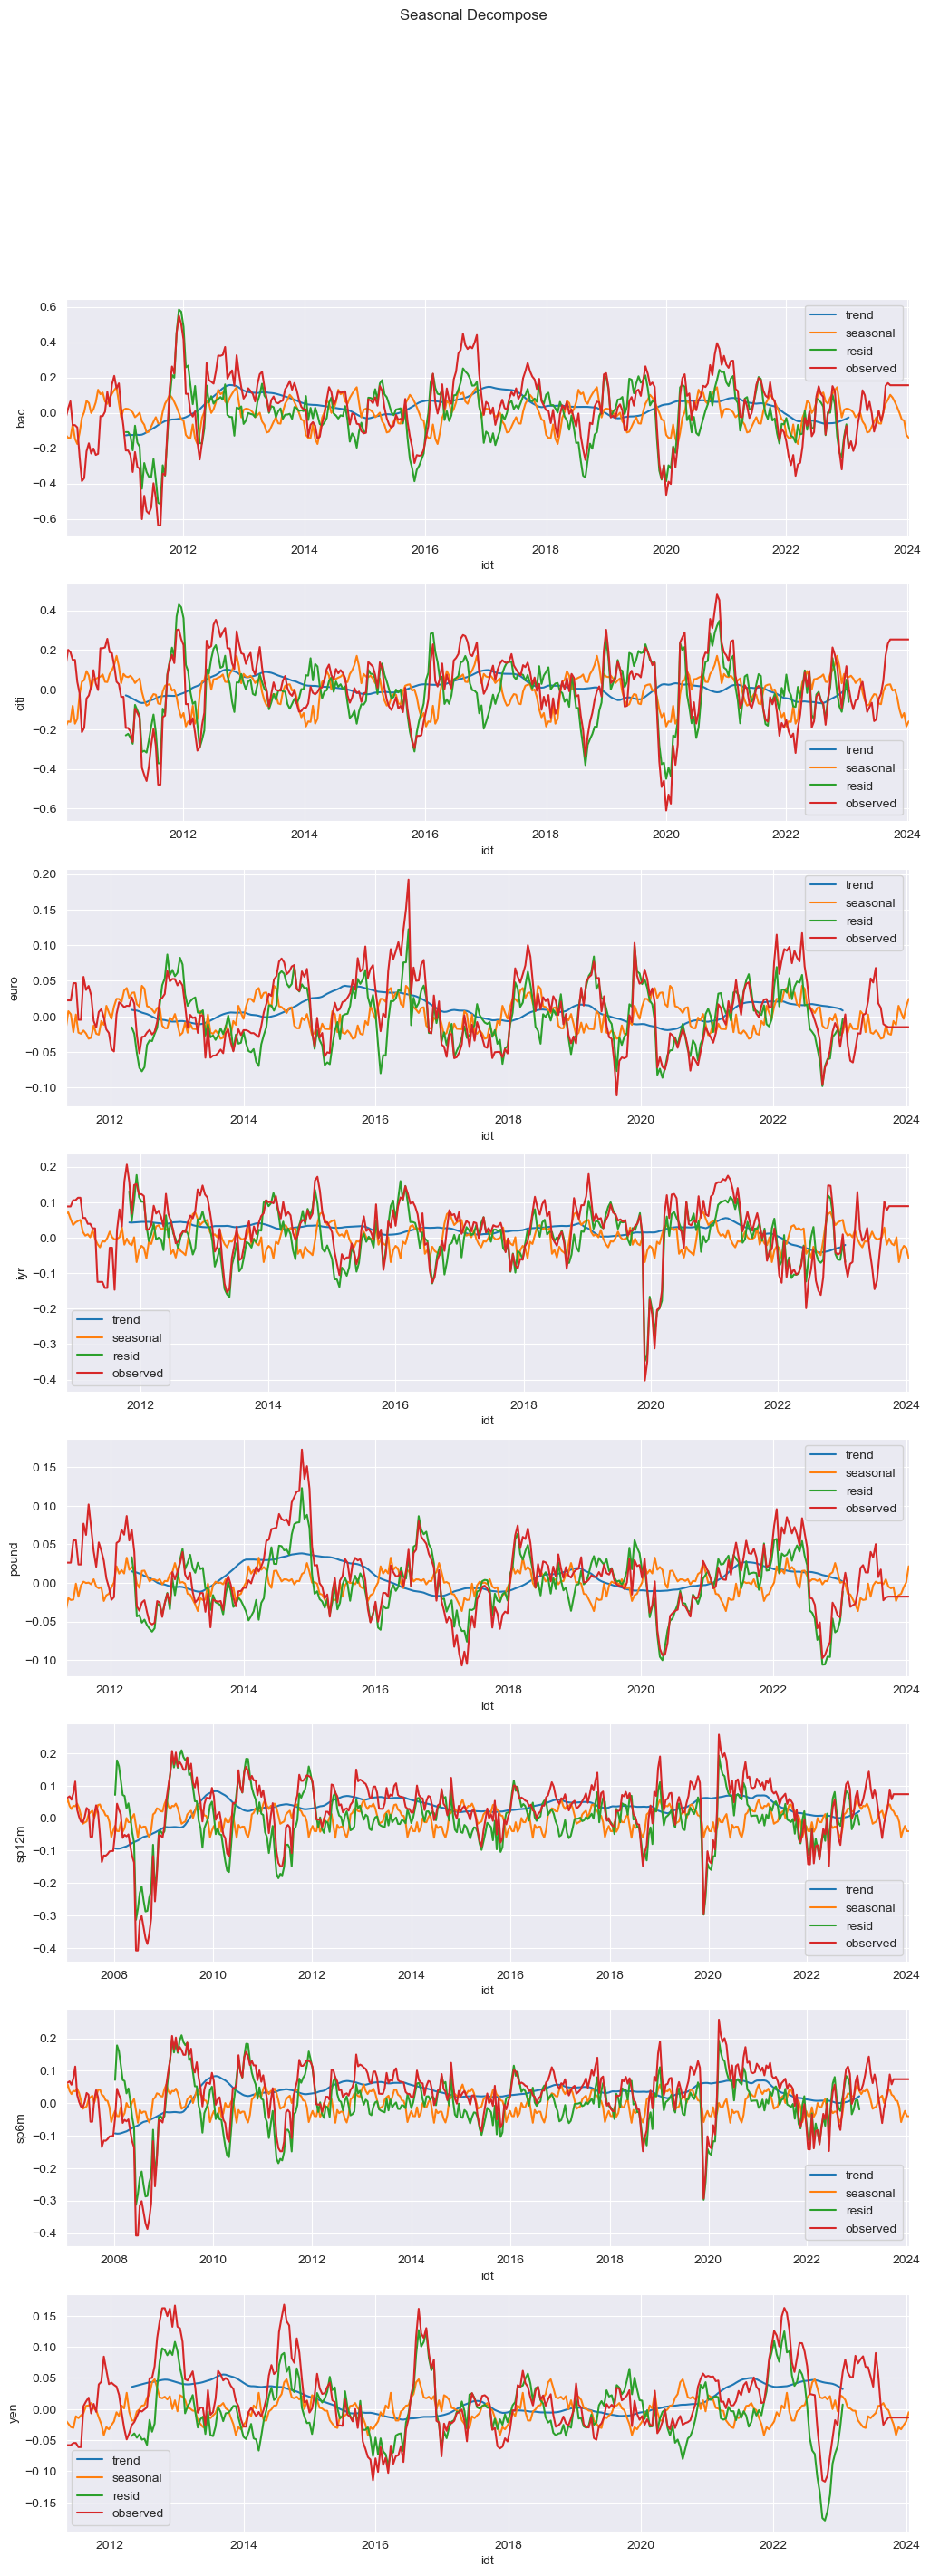

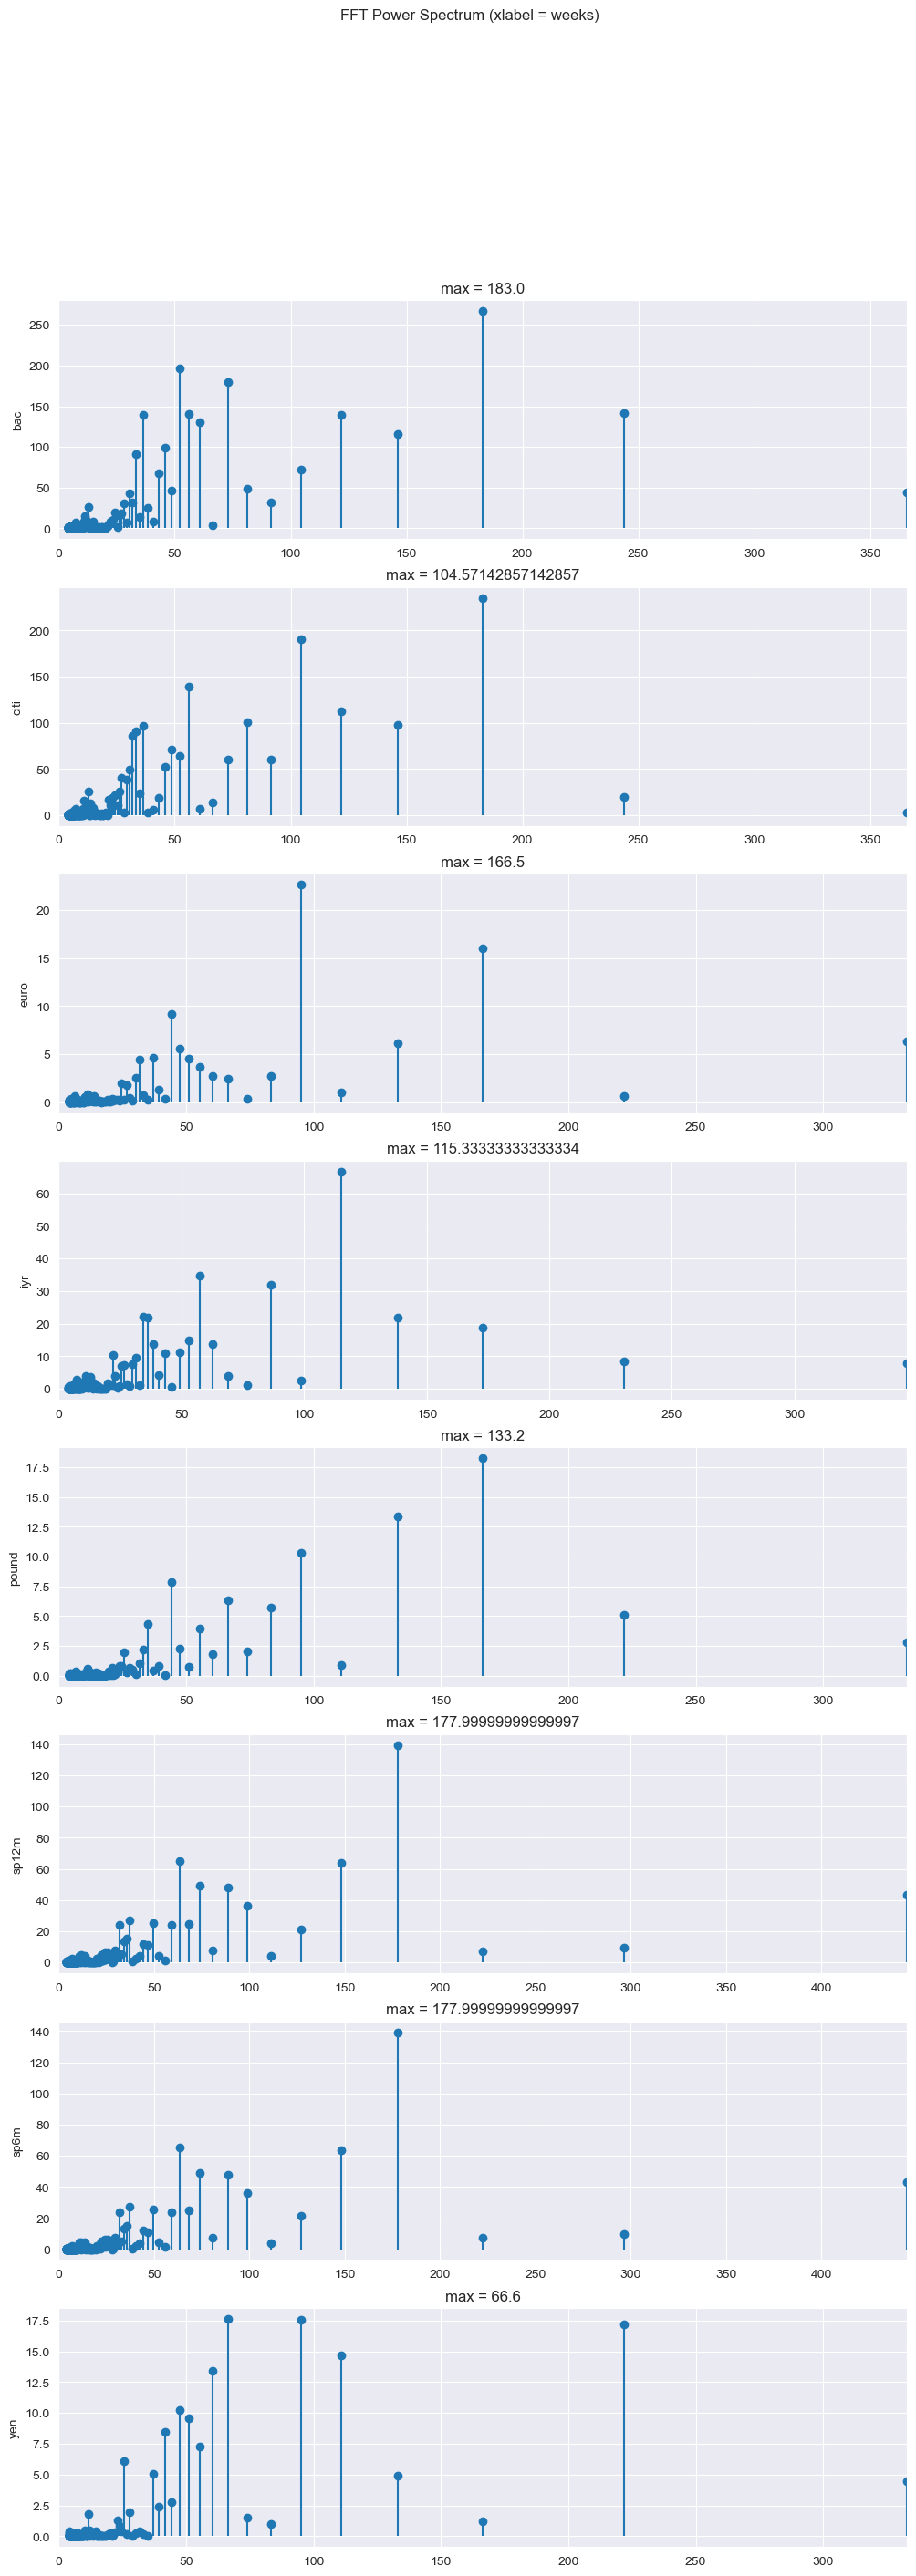

In [16]:
prep_regression_stat(df)

#### 3.2. Compare Regression 
We compare results of with/without probability as exogenous data for follow 4 regression
1. SARIMA
2. GARCH
3. Markov (Change Mean)
4. Markov (Change Volatility)

With a naive model (p=1, q=1), we see with probability tends to outperform by BIC for equity on all models, except for Garch-iyr.

For FX, results are more mixed.
- ARIMA: only yen outperforms with probability
- GARCH: everything outperform
- Markov Mean / Markov Volatility: only pound outperforms. 

In [17]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from arch import arch_model
import statsmodels.api as sm
from functools import partial

arima = compare_regressions(df, partial(SARIMAX, order=(1, 0, 1)))
garch = compare_regressions(
    df, partial(arch_model, p=1, q=1, mean='ARX', vol='GARCH'),
    model_ret_name="y", model_prob_name="x",
)
markov = compare_regressions(df, partial(sm.tsa.MarkovRegression, k_regimes=3))
markov_vol = compare_regressions(df, partial(sm.tsa.MarkovRegression, k_regimes=3,
                                             switching_variance=True))

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.01701D+00    |proj g|=  4.32744D-02

At iterate    5    f= -1.01705D+00    |proj g|=  4.31454D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     13      1     0     0   2.327D-04  -1.017D+00
  F =  -1.0170577861226666     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    0    f= -1.04919D+00    |proj g|=  8.09149D-02

At iterate    5    f= -1.07937D+00    |proj g|=  4.29988D-02

At iterate   10    f= -1.10235D+00    |proj g|=  9.73149D-01

At iterate   15    f= -1.10529D+00    |proj g|=  2.37345D-03

At iterate   20    f= -1.10540D+00    |proj g|=  2.34866D-02

At iterate   25    f= -1.10543D+00    |proj g|=  1.39329D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     36      1     0     0   4.478D-06  -1.105D+00
  F =  -1.1054313545975929     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.27375D+00    |proj g|=  3.21654D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      3      9      1     0     0   1.537D-02  -2.274D+00
  F =  -2.2737669695051621     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.2

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f= -1.57995D+00    |proj g|=  2.83855D+00

At iterate   10    f= -1.60475D+00    |proj g|=  1.13132D-01

At iterate   15    f= -1.61358D+00    |proj g|=  1.31457D+00

At iterate   20    f= -1.62472D+00    |proj g|=  2.46254D-01

At iterate   25    f= -1.62766D+00    |proj g|=  8.64237D-02

At iterate   30    f= -1.62877D+00    |proj g|=  4.79004D-02

At iterate   35    f= -1.62885D+00    |proj g|=  8.26225D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     36     50      1     0     0   8.262D-05  -1.629D+00
  F =  -1.6288466953302971     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   40    f= -2.46357D+00    |proj g|=  5.06283D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     44     53      1     0     0   2.250D-03  -2.464D+00
  F =  -2.4635886727190193     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.67289D+00    |proj g|=  1.78869D-01

At iterate    5    f= -1.67291D+00    |proj g|=  4.94385D-02

At iterate   10    f= -1.67292D+00    |proj g|=  8.28783D-03

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f= -1.80352D+00    |proj g|=  4.86640D-01

At iterate   30    f= -1.81410D+00    |proj g|=  1.08299D-01

At iterate   35    f= -1.81493D+00    |proj g|=  2.26880D-03

At iterate   40    f= -1.81493D+00    |proj g|=  1.79388D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     42     94      2     0     0   6.413D-05  -1.815D+00
  F =  -1.8149301075853110     

ABNORMAL_TERMINATION_IN_LNSRCH                              
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/Users/claircui/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.70103D+00    |proj g|=  1.87432D-01

At iterate    5    f= -1.79356D+00    |proj g|=  1.25234D-01

At iterate   10    f= -1.80540D+00    |proj g|=  2.83564D-01

At iterate   15    f= -1.81945D+00    |proj g|=  4.93262D-01

At iterate   20    f= -1.82024D+00    |proj g|=  1.94771D-02

At iterate   25    f= -1.82160D+00    |proj g|=  1.74251D-02

At iterate   30    f= -1.82161D+00    |proj g|=  8.76750D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -2.30671D+00    |proj g|=  3.13427D-01

At iterate    5    f= -2.30681D+00    |proj g|=  6.67345D-01

At iterate   10    f= -2.31299D+00    |proj g|=  3.95879D+00

At iterate   15    f= -2.31598D+00    |proj g|=  5.25991D-01

At iterate   20    f= -2.32307D+00    |proj g|=  4.98672D+00

At iterate   25    f= -2.34902D+00    |proj g|=  8.69661D-02

At iterate   30    f= -2.34913D+00    |proj g|=  2.45293D-01

At iterate   35    f= -2.34924D+00    |proj g|=  6.97773D-03

At iterate   40    f= -2.34926D+00    |proj g|=  1.87705D-01

At iterate   45    f= -2.34951D+00    |proj g|=  1.17102D-01

At iterate   50    f= -2.34951D+00    |proj g|=  4.60937D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Users/claircui/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/claircui/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.03818. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/claircui/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.03755. Parameter
estimation work better when this value is between

Iteration:     12,   Func. Count:    101,   Neg. LLF: -211.74526349712488
Iteration:     13,   Func. Count:    108,   Neg. LLF: -211.9862787340811
Iteration:     14,   Func. Count:    115,   Neg. LLF: -212.0214130906701
Iteration:     15,   Func. Count:    122,   Neg. LLF: -212.02761858803638
Iteration:     16,   Func. Count:    129,   Neg. LLF: -212.03034067600507
Iteration:     17,   Func. Count:    136,   Neg. LLF: -212.03113665634515
Iteration:     18,   Func. Count:    143,   Neg. LLF: -212.03122664365253
Iteration:     19,   Func. Count:    150,   Neg. LLF: -212.03123042589493
Iteration:     20,   Func. Count:    156,   Neg. LLF: -212.03123024883203
Optimization terminated successfully    (Exit mode 0)
            Current function value: -212.03123042589493
            Iterations: 20
            Function evaluations: 156
            Gradient evaluations: 20
Iteration:      1,   Func. Count:      6,   Neg. LLF: 186964.32156956635
Iteration:      2,   Func. Count:     15,   Neg. LL

/Users/claircui/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.008828. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/claircui/anaconda3/lib/python3.11/site-packages/arch/univariate/base.py:310: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.008791. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/claircui/anaconda3/lib/python3.11/site-packages/a

In [21]:
compare_regression_eval(arima, "bic").loc[market_list]

,with,without,diff
bac,-756.063734,-726.778399,-29.285335
citi,-779.662585,-740.491682,-39.170903
iyr,-1097.929719,-1044.897515,-53.032205
sp6m,-1590.743287,-1470.614617,-120.128671
sp12m,-1584.797424,-1470.614617,-114.182808
euro,-1492.606858,-1496.904374,4.297516
pound,-1611.709344,-1616.036489,4.327145
yen,-1535.735608,-1530.343115,-5.392493


In [22]:
compare_regression_eval(garch, "bic").loc[market_list]

,with,without,diff
bac,-388.646661,-379.873876,-8.772785
citi,-410.422326,-402.917952,-7.504374
iyr,-796.958397,-799.489091,2.530694
sp6m,-1159.498385,-1130.987225,-28.511161
sp12m,-1144.138764,-1130.987225,-13.151540
euro,-1125.479712,-1164.753058,39.273346
pound,-1236.709034,-1245.960728,9.251694
yen,-1159.997287,-1170.175364,10.178077


In [23]:
compare_regression_eval(markov, "bic").loc[market_list]

,with,without,diff
bac,-428.271671,-421.443514,-6.828157
citi,-545.607906,-490.821047,-54.786859
iyr,-956.845618,-921.705306,-35.140312
sp6m,-1318.419962,-1209.763192,-108.656770
sp12m,-1302.755745,-1209.763192,-92.992553
euro,-1346.721922,-1367.149372,20.427450
pound,-1397.681004,-1374.814364,-22.866640
yen,-1217.513126,-1225.895936,8.382811


In [24]:
compare_regression_eval(markov_vol, "bic").loc[market_list]

,with,without,diff
bac,-447.920025,-430.671287,-17.248738
citi,-561.089440,-505.700350,-55.389091
iyr,-986.296196,-963.457737,-22.838458
sp6m,-1403.600617,-1242.762671,-160.837946
sp12m,-1373.150578,-1242.762671,-130.387907
euro,-1346.083413,-1370.332699,24.249286
pound,-1406.738826,-1327.394545,-79.344281
yen,-1213.596677,-1238.268635,24.671958
